In [68]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [69]:
import os

In [70]:
img_files = os.listdir("pdf2png")

In [94]:
img = cv2.imread("pdf2png/ZUG-GU22_01_IST_20140922-1.png", 0)

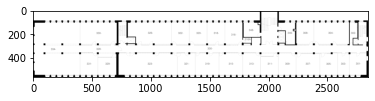

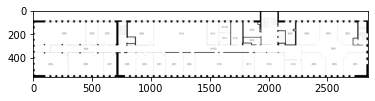

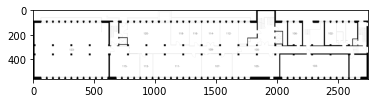

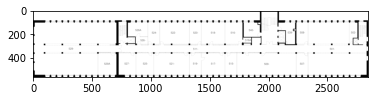

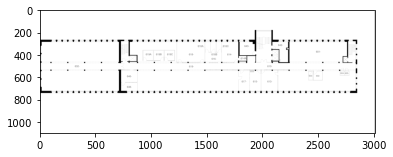

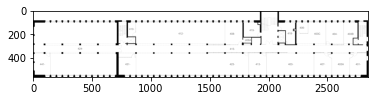

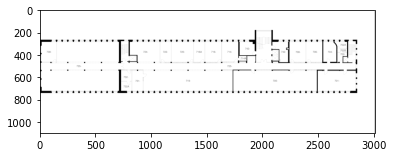

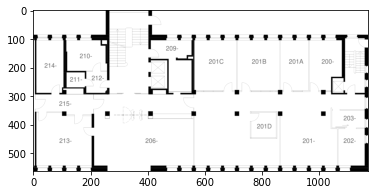

In [112]:
for img_file in img_files:
    plt.figure()
    img = cv2.imread("pdf2png/" + img_file, 0)
    img2 = img[600:1700,200:3400]
    a,b = np.where(img2 <=100)
    plt.imshow(img2[min(a):max(a),min(b):max(b)], cmap="gray")

In [96]:
img2 = img[600:1700,200:3400]

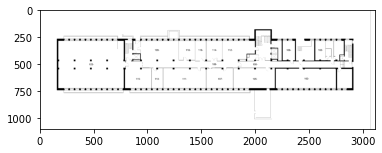

In [97]:
plt.imshow(np.where(img2 > 200, 255, 0), cmap="gray")

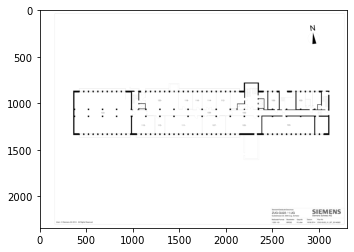

In [98]:
plt.imshow(img, cmap="gray")

In [66]:
img2.shape

(1100, 3109)

In [37]:
img3 = np.where(img2 > 200, 255, 0)

In [106]:
a,b = np.where(img2 <=100)

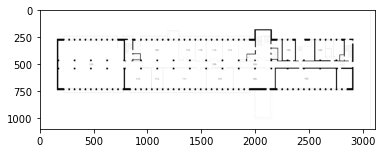

In [107]:
plt.imshow(img2, cmap="gray")

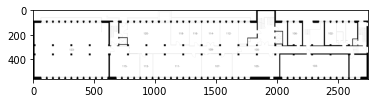

In [108]:
plt.imshow(img2[min(a):max(a),min(b):max(b)], cmap="gray")


(array([6.9340e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4140e+03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.4060e+03, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7600e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.6570e+03, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 5.7200e+02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0830e+03, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4250e+03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.8000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.4950e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

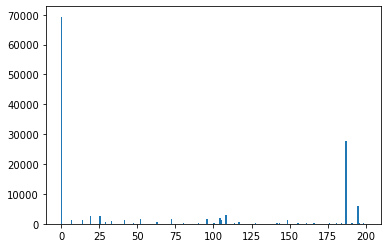

In [102]:
plt.hist(img2.flatten(), bins=256, range=(0,200))